# Refine a grid for an existing model and compare results
This notebook will demonstrate how to use the function that converts a structured
grid MODFLOW 6 model to a vertex grid with quadtree refinement around a user-defined
feature. It will also demonstrate how the function handles aquifer properties,
specified fluxes, and properties of head-dependent flux boundaries. Budget items
will be compared to asses the impact of the refinement scheme on simulated results. 
This function was designed to be used for automated refinement around (hundreds of) 
pumping wells to improve accuracy of simulated drawdown and particle tracking around
the wells. The function could be used for other purposes, however, and this notebook 
is meant to help a user to judge what may or may not be appropriate to do using 
this approach.

Import libraries

In [1]:
# IMPORT
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString
import flopy
from mfmodify import quadtree_refine_dis_gwf
from mfmodify.plotting import (
    plot_compare_final_vols, 
    plot_compare_obs_sim, 
    plot_interpolated_heads)
from mfmodify.utils import pak_sp_prop_to_array

Set some inputs. 
refine xys is used to create a very simple line as the feature
that the function will refine the grid around. A geopandas geodataframe will be 
created from these xys. The refinement function accepts a geodataframe that can 
contain sinlge or multiple point, linestring, or polygon features. 
refine_level sets the number of times the original grid will be divided into 4 
quadrants with quadtree refinement (using gridgen).

In [2]:
# INPUT
sim_ws_orig = os.path.join('historic_models', 'model_v1-metric')
sim_ws_new = os.path.join('regrid_tests', 'tvgwfm', 'historic_regrid_same_stresses')
refine_xys = [(2275000, 1370000), (2295000, 1390000)]
refine_level = 5

Load the original simulation and plot the original grid along with the refinement feature (line).

In [3]:
# BODY
# load orignal simulation
sim_orig = flopy.mf6.MFSimulation.load(sim_ws=sim_ws_orig, verbosity_level=0)

<Axes: >

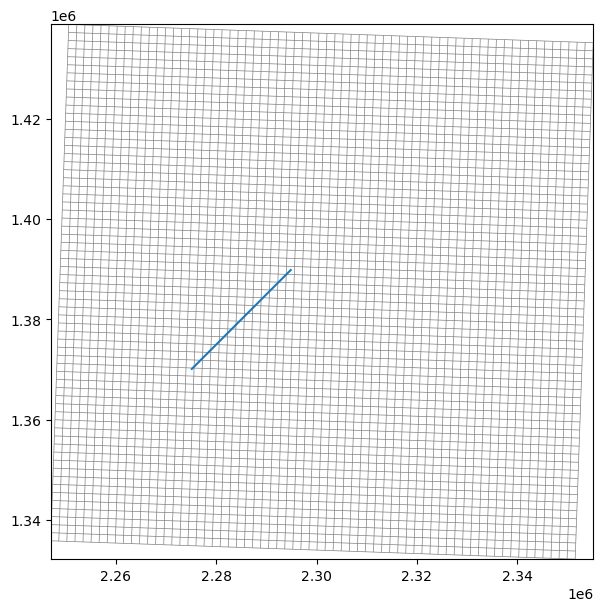

In [4]:
# create a refinement geodataframe
refine_linestring = LineString(refine_xys)
refine_gdf = gpd.GeoDataFrame({'id': ['example_line'], 'geometry': [refine_linestring]})

# plot grid and refinement line
fig, ax = plt.subplots(1,1, figsize=(7,7))
sim_orig.get_model().modelgrid.plot(ax=ax, linewidth=0.5)
refine_gdf.plot(ax=ax)

Now we'll run the function that will refine the grid around that line. The function returns a flopy simulation object, from which you can then simply write model files and the new model. It is also possible to add new modules or edit existing modules with the simulation object prior to writing and running. For now we'll create the simulation object. The function also returns a dataframe relating the new and old grid cells and a dictionary that locates the refinement feature(s) for all layers on the new grid. 

This function works by first using gridgen to perform quadtree refinement. It then gets disv parameters from this grid along with a dataframe that maps original and new cells and their relative area. New simulation and groundwater flow model obejcts are created by loading all parameters from each MODFLOW module object, converting any properties or fluxes that should be reduced when a cell is divided, restructuring any that must be defined differently for a disv grid, and then recreating the module objects.

In [5]:
# refine simulation around line
sim_new, grid_relate, feature_locs = quadtree_refine_dis_gwf(
    sim_orig,
    refine_gdf,
    refine_level,
    sim_ws_new=sim_ws_new
)

Show a selection from the grid_relate dataframe. The cellid_disu column is unused. Maybe I'll get around to doing a dis to disu converter...

In [6]:
grid_relate.iloc[1920:1926, :]

,cellid_disv,cellid_disu,prop_dis_area
cellid_dis,,,
"(0, 29, 26)","(0, 1920)",1920,1.0000
"(0, 29, 27)","(0, 1921)",1921,0.2500
"(0, 29, 27)","(0, 1922)",1922,0.2500
"(0, 29, 27)","(0, 1923)",1923,0.2500
"(0, 29, 27)","(0, 1924)",1924,0.0625
"(0, 29, 27)","(0, 1925)",1925,0.0625


Show the feature location information. This is a dictionary where each refinement feature is a key (only one in this case) and a dataframe with location information are the items.

In [7]:
feature_locs['example_line'].head()

,nodenumber,arcid,length,starting_distance,ending_distance,SHAPEID,cellid_disv,cellid_disu
0,5806,0,42.61550,0.0000,42.6155,0,"(0, 5806)",5806
1,1958,0,45.45490,28238.8000,28284.3000,0,"(0, 1958)",1958
2,5807,0,2.29137,42.6155,44.9069,0,"(0, 5807)",5807
3,1968,0,26.71370,28212.1000,28238.8000,0,"(0, 1968)",1968
4,5801,0,68.76560,44.9069,113.6730,0,"(0, 5801)",5801


Let's look at what happened to the grid and properties. First, the grid and refinement line.

<Axes: >

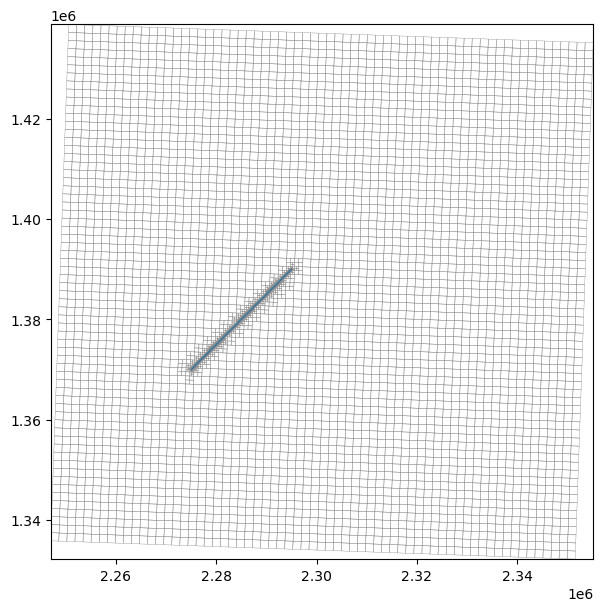

In [8]:
# plot grid and refinement line
fig, ax = plt.subplots(1,1, figsize=(7,7))
sim_new.get_model().modelgrid.plot(ax=ax, linewidth=0.25)
refine_gdf.plot(ax=ax, linewidth=0.75)

Aquifer properties from each original grid cell are assigned to each subdivided cell in the disv grid.

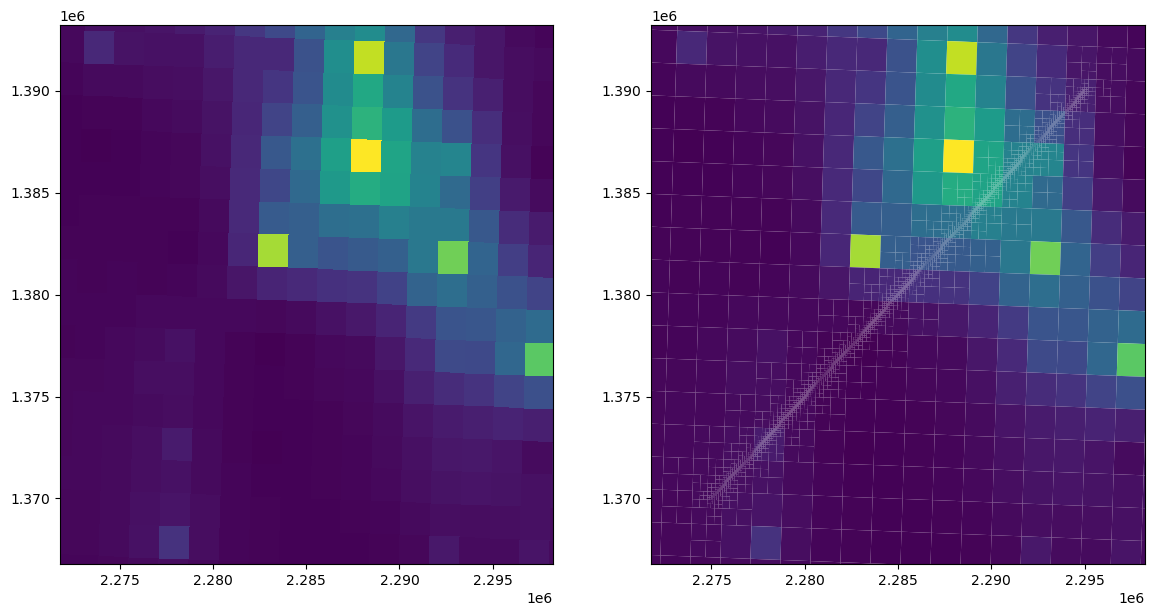

In [9]:
# get flopy plotmapview objects for each model and plot aquifer properties
# load models
gwf_orig = sim_orig.get_model()
gwf_new = sim_new.get_model()
# get k arrays for each
k_orig = gwf_orig.get_package('npf').k.data
k_new = gwf_new.get_package('npf').k.data
# create a figure and axes
fig, (ax_orig, ax_new) = plt.subplots(1, 2, figsize=(14, 7))
# get x and y extents
xs, ys = refine_linestring.xy
buffer = 3220
extent = (min(xs)-buffer, max(xs)+buffer, min(ys)-buffer, max(ys)+buffer)
# make plot map view objects
pmv_orig = flopy.plot.PlotMapView(gwf_orig, extent=extent, ax=ax_orig)
pmv_new = flopy.plot.PlotMapView(gwf_new, extent=extent, ax=ax_new)
# plot aquifer properties
pmv_orig.plot_array(k_orig)
pmv_new.plot_array(k_new)

Boundary cells for the new grid are identified in the same way. If a cell had a boundary
in the original grid all subdivided cells will also have that boundary. Note that the river
in this model is represented with the simple RIV module. This approach for refining boundaries
would not work for the SFR package, which requires connection relationships between segments to be defined.

<Axes: >

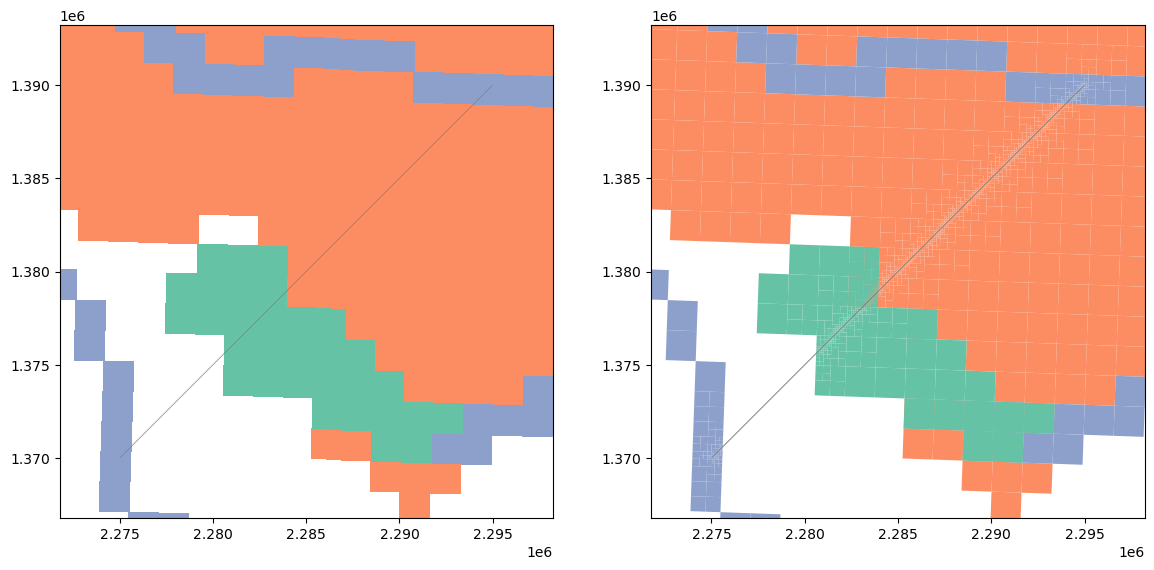

In [10]:
# Shows cells with drain, ghb, and river boundaries
# get axes and plotmapviews again
fig, (ax_orig, ax_new) = plt.subplots(1, 2, figsize=(14, 7))
pmv_orig = flopy.plot.PlotMapView(gwf_orig, extent=extent, ax=ax_orig)
pmv_new = flopy.plot.PlotMapView(gwf_new, extent=extent, ax=ax_new)
# plot drain locations
pmv_orig.plot_bc('DRN', color='#fc8d62')
pmv_new.plot_bc('DRN', color='#fc8d62')
# plot riv locations
pmv_orig.plot_bc('RIV', color='#8da0cb')
pmv_new.plot_bc('RIV', color='#8da0cb')
# plot ghb locations
pmv_orig.plot_bc('GHB', color='#66c2a5')
pmv_new.plot_bc('GHB', color='#66c2a5')
refine_gdf.plot(ax=ax_orig, linewidth=0.5, color='grey')
refine_gdf.plot(ax=ax_new, linewidth=0.7, color='grey')

The boundary locations are straightforward. However, the refinement function also attempts to scale any property or flow that is area-dependent. Each of the boundaries above have a conductance property that is in theory proportional to the cross sectional boundary area. Even with this scaling, the head-dependent boundaries fluxes are likely to differ from the original model as horizontal distances - and therefore horizontal gradients - between boundary and adjacent cells are different. 
Let's see how the drain conductance property was adjusted.

<Axes: >

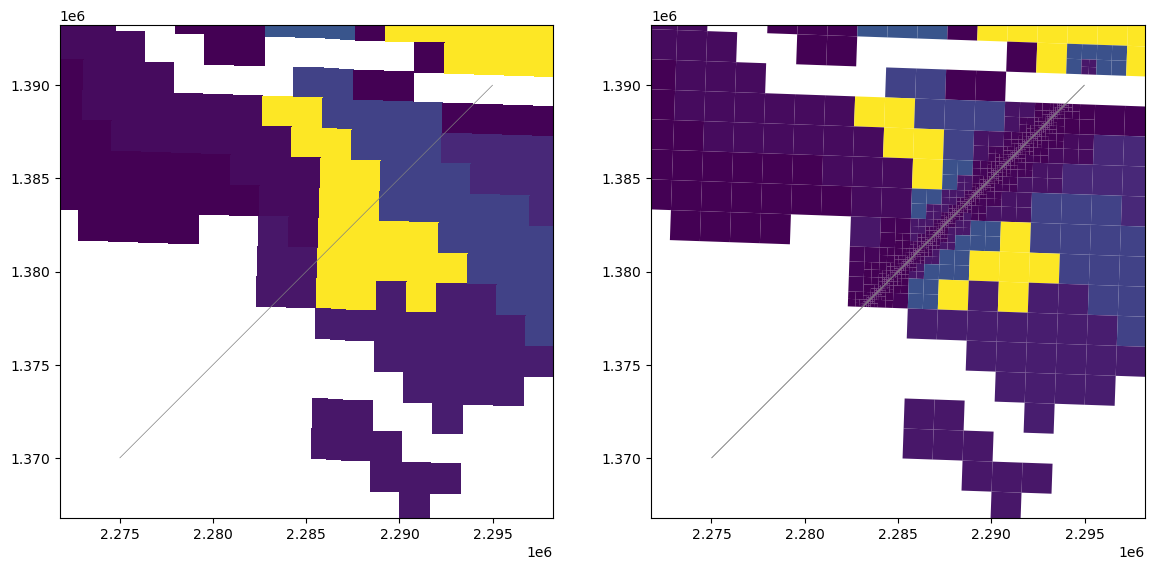

In [16]:
# Show drain conductance properties
# get axes and plotmapviews again
# fig, (ax_orig, ax_new) = plt.subplots(1, 2, figsize=(14, 7))
# pmv_orig = flopy.plot.PlotMapView(gwf_orig, extent=extent, ax=ax_orig)
# pmv_new = flopy.plot.PlotMapView(gwf_new, extent=extent, ax=ax_new)
# get conductance
drn_c_orig = pak_sp_prop_to_array(gwf_orig.get_package('drn'), 'cond', grid_relate, sp=0)
drn_c_new = pak_sp_prop_to_array(gwf_new.get_package('drn'), 'cond', grid_relate, sp=0)
# get axes and plotmapviews again
fig, (ax_orig, ax_new) = plt.subplots(1, 2, figsize=(14, 7))
pmv_orig = flopy.plot.PlotMapView(gwf_orig, extent=extent, ax=ax_orig)
pmv_new = flopy.plot.PlotMapView(gwf_new, extent=extent, ax=ax_new)
# plot drain locations
pmv_orig.plot_array(drn_c_orig)
pmv_new.plot_array(drn_c_new)
# plot line
refine_gdf.plot(ax=ax_orig, linewidth=0.5, color='grey')
refine_gdf.plot(ax=ax_new, linewidth=0.7, color='grey')

Specified fluxes are easier. The fluxes in each cell are allocated to each new cell in proportion to their area. If a time-series is used, the multiplier value for the cell will be scaled in proportion to the area. These specified fluxes should match almost perfectly with the original model. I won't plot any examples of these, but they should be the same idea as the plot above.

Run the model so we can compare output. This takes about 10 minutes on my laptop.

In [12]:
sim_new.write_simulation(silent=True)
sim_new.run_simulation(silent=True)

(True, [])

Compare the coarse-scale total volumes

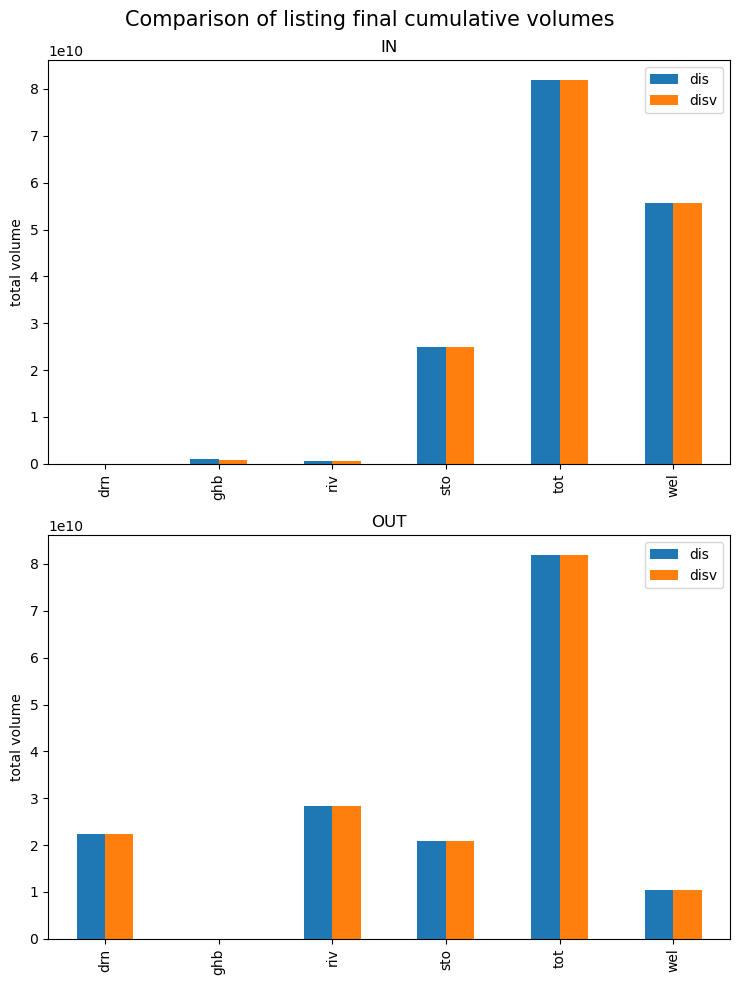

In [13]:
# Compare the final list entries as bar charts for each type (using helper function)
fig = plot_compare_final_vols(gwf_orig, gwf_new, names=['dis', 'disv'])

Compare observation file output. Most are nearly identical, but differences can be seen in the drn, ghb (Lowell), and especially the riv observation groups that the refinement feature passes through.

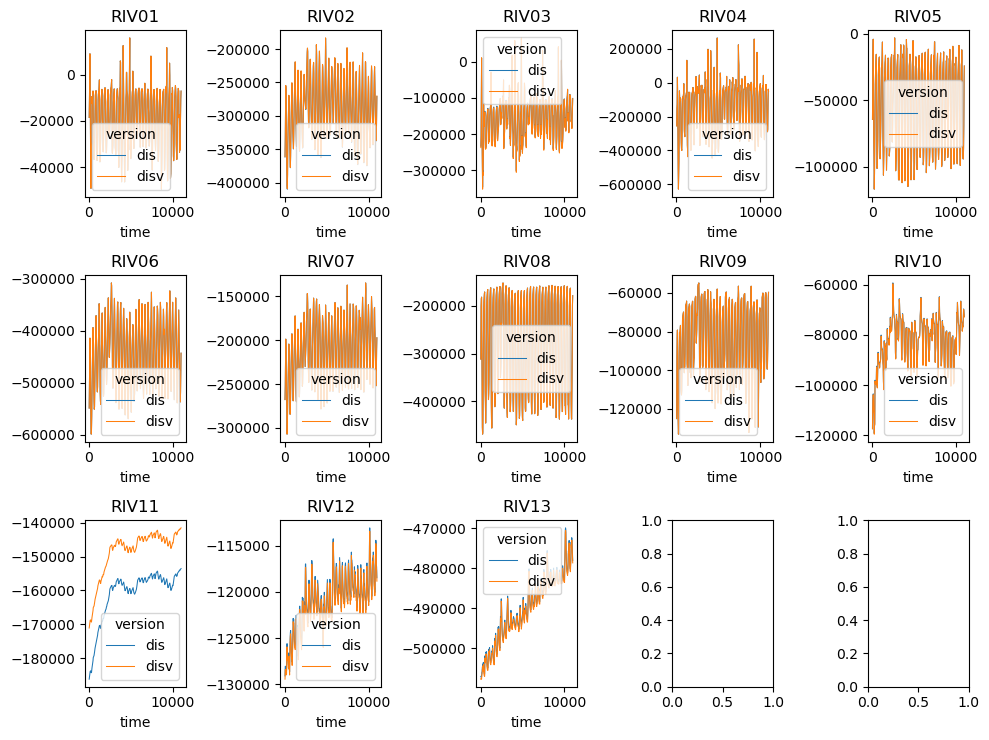

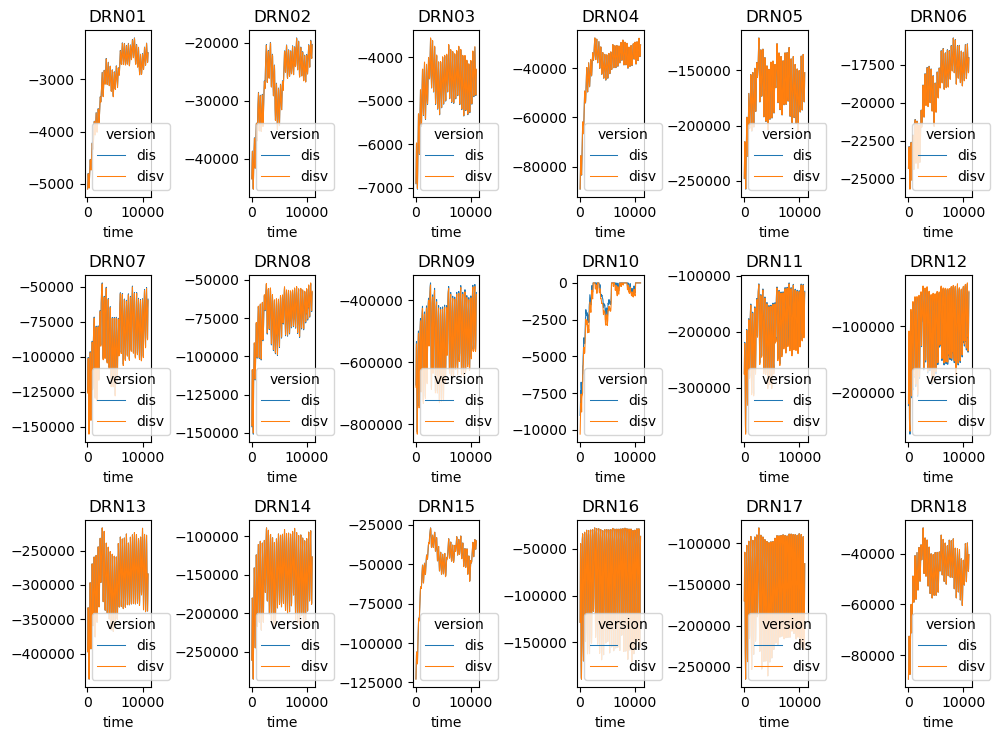

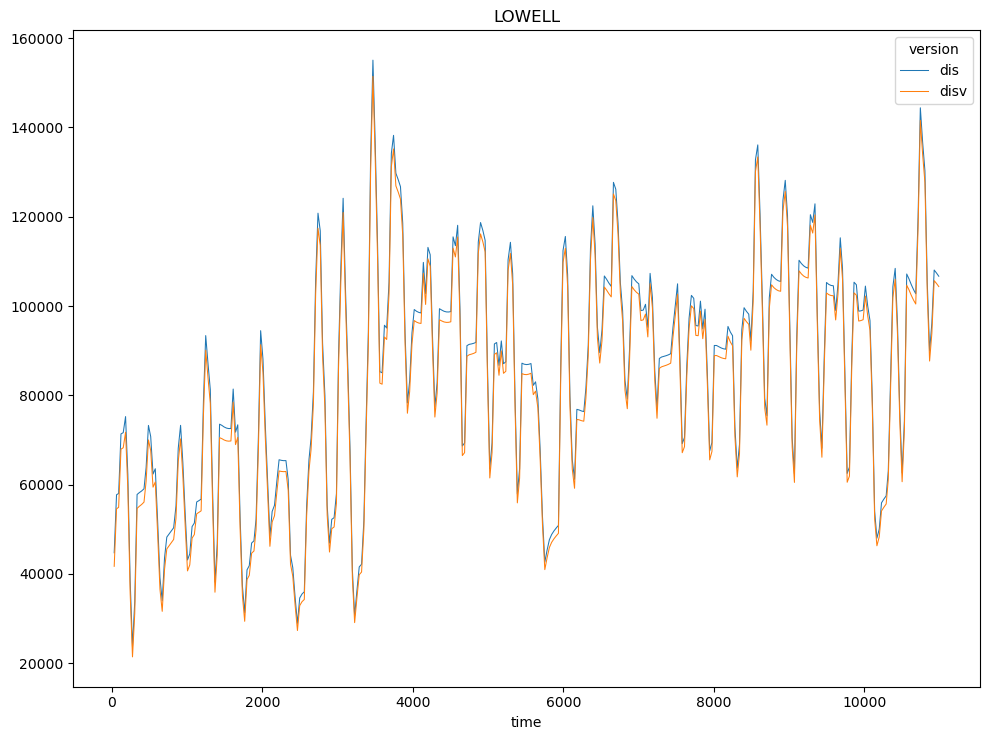

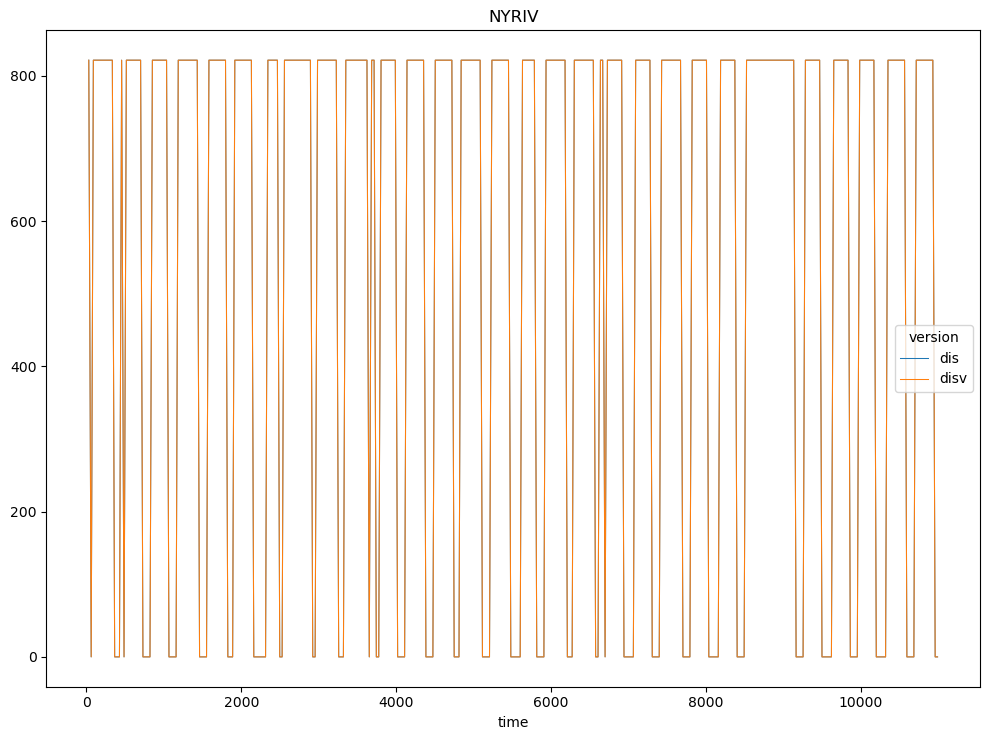

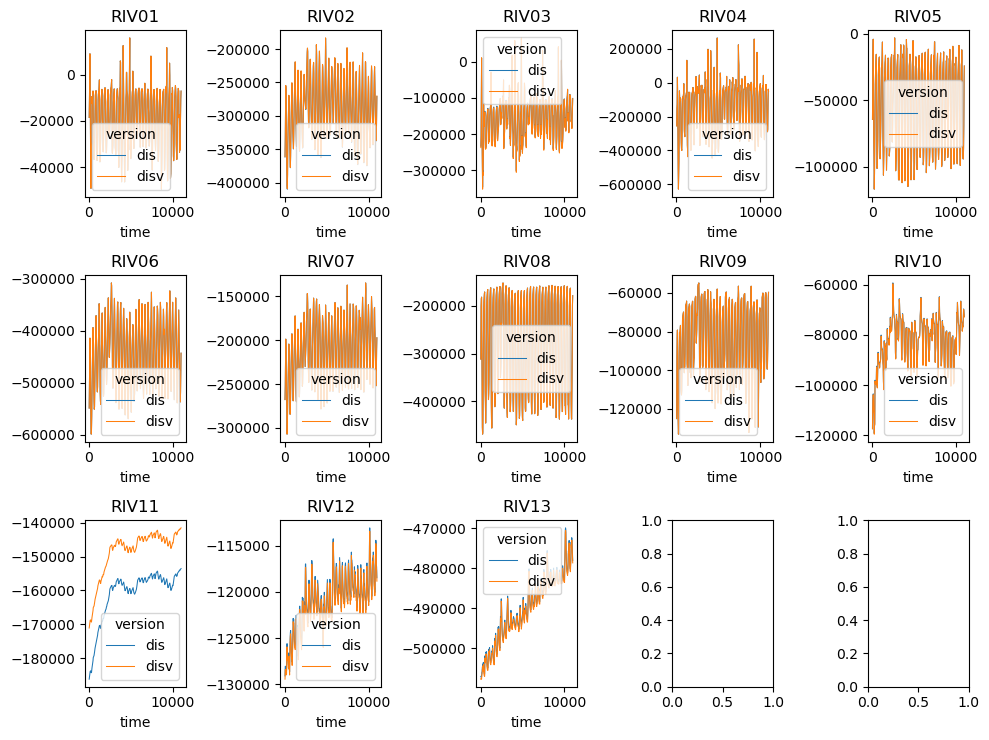

In [17]:
# make plots of all
plot_compare_obs_sim(sim_ws_orig, sim_ws_new, names=['dis', 'disv'], linewidth=0.75)

Lets compare the final heads in layer 1 along the refinement line. Differences between the models will be greatest along this line. There is a noticable difference on the left side where a dramatic gradient (and some flooded cells) appear in both versions of the model. The head remains elevated for a greater distance in the disv model. Note that the jagged pattern for the dis model on the right side is simply because the refinement line slices diagonally through the grid. A refinement line along a row or column would not result in such an oscillating pattern.

Text(0.5, 1.0, 'Cross-section of layer 1 head in final stress period along refinement line')

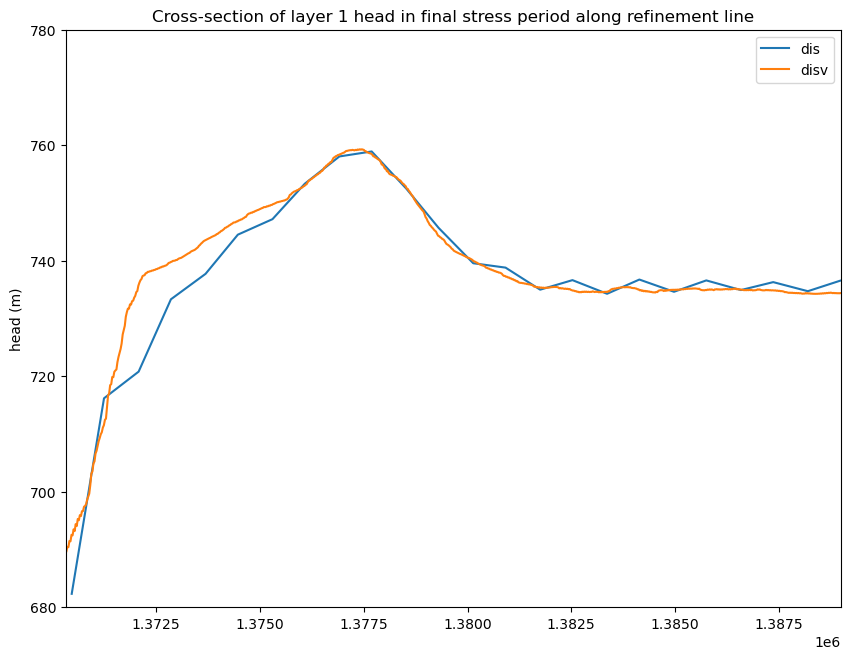

In [25]:
fig, ax = plt.subplots(1,1, figsize=(10, 7.5))
cmap=plt.get_cmap('tab10')
surf_orig = plot_interpolated_heads(gwf_orig, refine_xys, ax, linewidth=1.5, label='dis', color=cmap(0), grid=False)
surf_new = plot_interpolated_heads(gwf_new, refine_xys, ax, linewidth=1.5, label='disv', color=cmap(1), grid=False)
ax.set_ylim(680, 780)
ax.legend()
ax.set_ylabel('head (m)')
ax.set_title('Cross-section of layer 1 head in final stress period along refinement line')

Finally, let's make the same plot by offset the cross-section line by 5000 m (a little over 3 miles) to be just outside of the refined area, and then 10,000 m to be even further away.

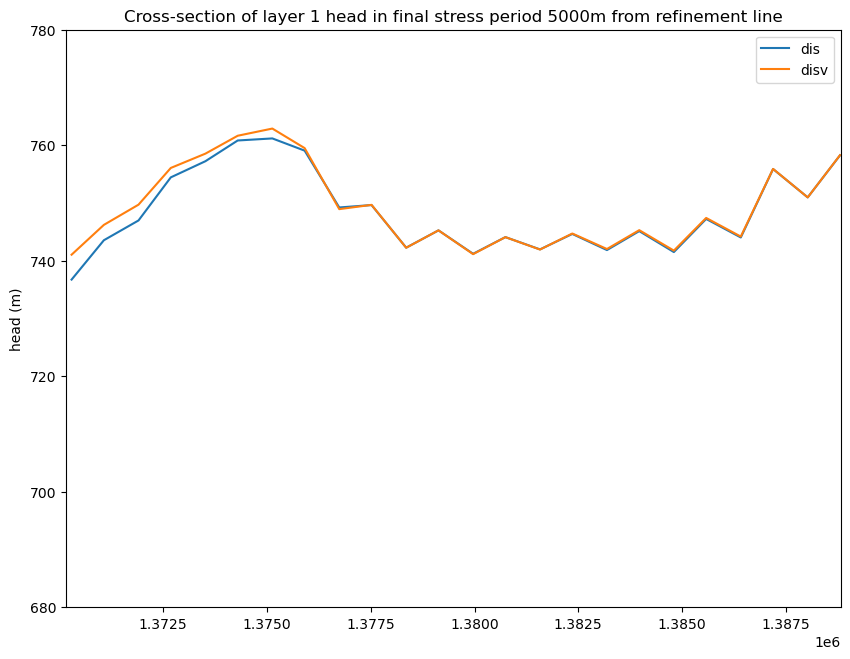

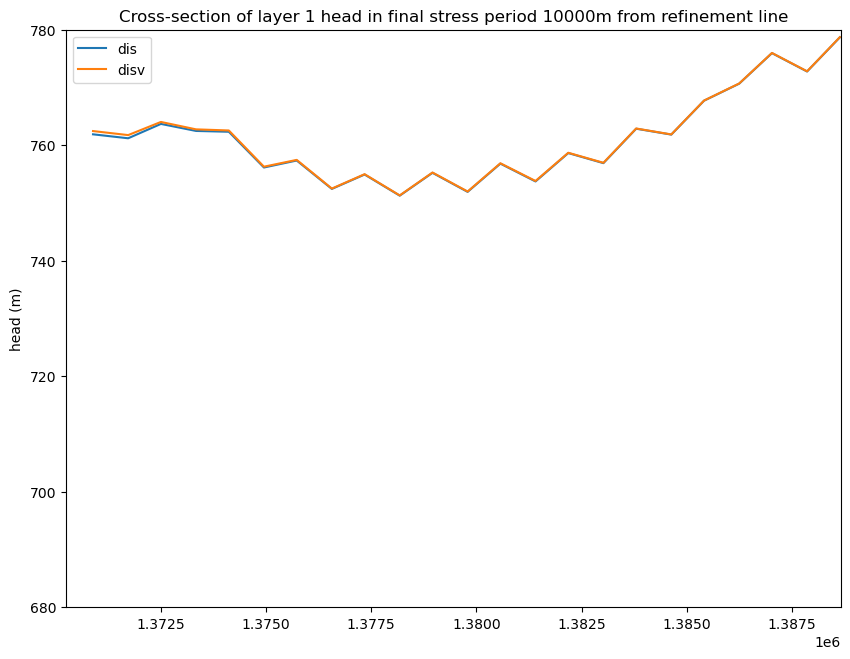

In [30]:
# make a new refinement xy
for offset in [5000, 10000]:
    refine_xys2 = [
        (refine_xys[0][0] + offset, refine_xys[0][1]),
        (refine_xys[1][0] + offset, refine_xys[1][1]),
    ]
    # repeat plot above
    fig, ax = plt.subplots(1,1, figsize=(10, 7.5))
    cmap=plt.get_cmap('tab10')
    surf_orig = plot_interpolated_heads(gwf_orig, refine_xys2, ax, linewidth=1.5, label='dis', color=cmap(0), grid=False)
    surf_new = plot_interpolated_heads(gwf_new, refine_xys2, ax, linewidth=1.5, label='disv', color=cmap(1), grid=False)
    ax.set_ylim(680, 780)
    ax.legend()
    ax.set_ylabel('head (m)')
    ax.set_title(f'Cross-section of layer 1 head in final stress period {offset}m from refinement line')